In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

data_path = 'TravelInsurancePrediction.csv'
df = pd.read_csv(data_path)

df.drop('Unnamed: 0', axis=1, inplace=True)
categorical_columns = ['ChronicDiseases', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance']
for col in categorical_columns:
    df[col] = df[col].astype('object')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   object
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   object
dtypes: int64(3), object(6)
memory usage: 139.8+ KB
None


## Data Type Transformation

In the original dataset, certain variables represented as numbers are actually categorical in nature. These are the fields `ChronicDiseases`, `GraduateOrNot`, `FrequentFlyer`, `EverTravelledAbroad`, and `TravelInsurance`. They contain yes/no information that was encoded as 0 and 1.

- `ChronicDiseases`: Indicates whether the client has chronic diseases.
- `GraduateOrNot`: Whether the client is a college graduate.
- `FrequentFlyer`: Whether the client frequently books flights (based on booking history).
- `EverTravelledAbroad`: Whether the client has traveled abroad.
- `TravelInsurance`: Whether the client purchased the travel insurance package in 2019.

We have transformed these fields from numerical (`int64`) to categorical (`object`) to more accurately reflect their nature and to facilitate further analysis. This will also enable us to use these variables as categorical features in machine learning model building.

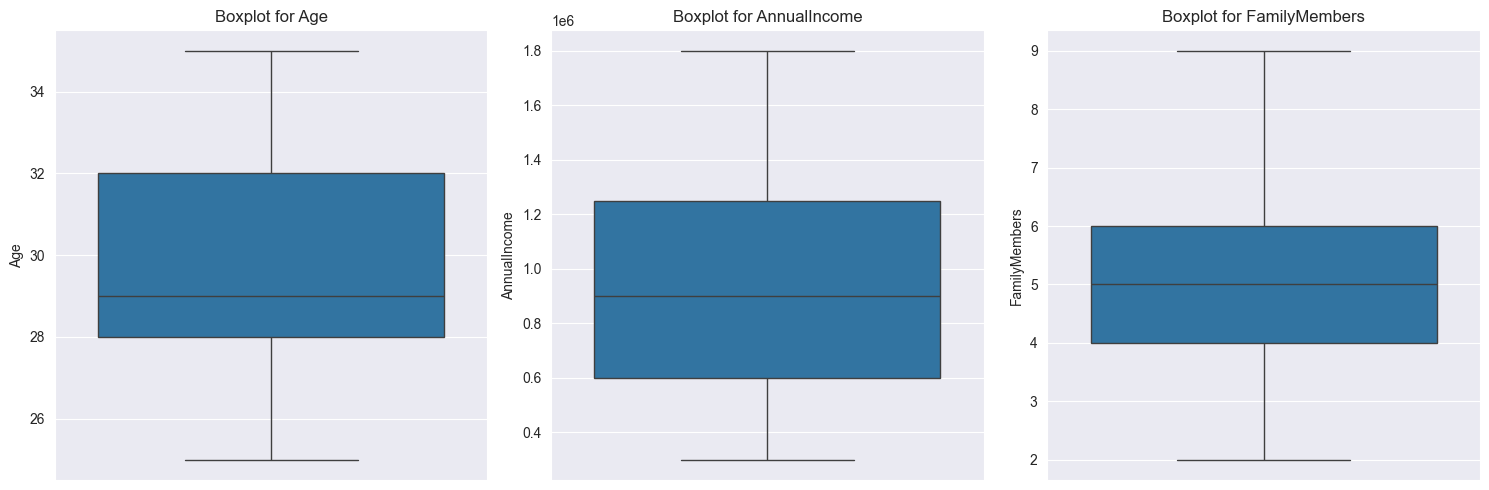

In [27]:
num_features = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 5))
for i, feature in enumerate(num_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df[feature])
    plt.title(f'Boxplot for {feature}')

plt.tight_layout()
plt.show()

## Visualization of Numerical Features

We have visualized the distribution of the numerical features `Age`, `AnnualIncome`, and `FamilyMembers` using boxplots. These plots are essential for identifying the spread of the values and detecting outliers, which could be influential points or anomalies in our dataset.

- The `Age` boxplot shows a fairly symmetrical distribution, suggesting that the age of customers is normally distributed around the median.
- The `AnnualIncome` boxplot indicates a wider range of values, with some potential outliers on the higher end. These outliers represent customers with significantly higher annual incomes compared to the rest.
- The `FamilyMembers` boxplot displays a compact distribution with few mild outliers. The majority of customers have a family size that falls within a narrow range, which is typical for this demographic.

Understanding the distribution of these variables is critical for further analysis and for making informed decisions when preprocessing data for machine learning modeling.

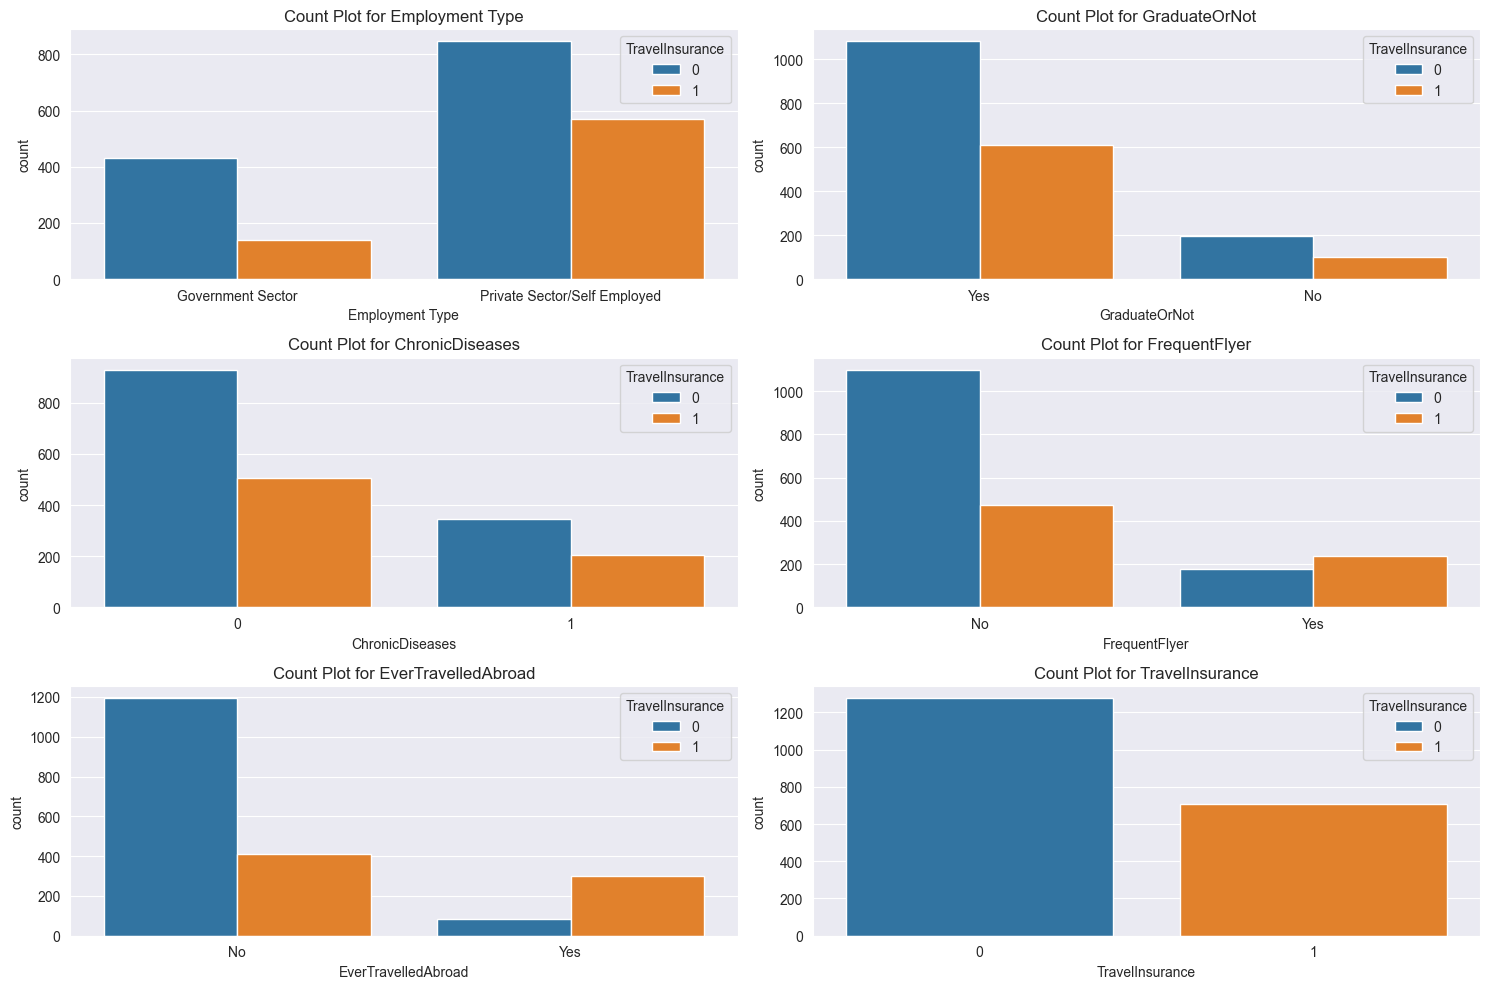

In [28]:
# Categorical features EDA
categorical_features = df.select_dtypes(include=['category', 'object']).columns

# Count plots for categorical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i + 1)  # Adjust the grid size according to the number of categorical features
    sns.countplot(x=df[feature], hue=df['TravelInsurance'])
    plt.title(f'Count Plot for {feature}')
    plt.tight_layout()

plt.show()

## Exploratory Data Analysis of Categorical Features

In this section, we have created count plots for each categorical feature in the dataset, comparing the distribution of categories with respect to the target variable `TravelInsurance`. These visualizations help us understand the relationship between the categorical features and the likelihood of a customer purchasing travel insurance.

- For each categorical feature, we observe how the categories compare between customers who did and did not purchase travel insurance.
- This analysis can reveal patterns and trends that may be influential in predicting the target variable.
- Such insights are valuable for feature selection during the model building process and can guide the creation of feature engineering strategies.

In [29]:
# One-hot encoding of categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                                columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical features and replace with encoded features
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, encoded_features], axis=1)

# Split the data into features and target
X = df.drop('TravelInsurance_1', axis=1)
y = df['TravelInsurance_1'].astype(int)  # Ensure the target is encoded as integer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(1589, 8) (398, 8)


Now we have training data with 1589 samples and testing data with 398 samples, each with 8 features. This setup is suitable for moving on to the next stage, which is model training.

In [30]:
# Fit the model to the training data
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)

# Predict on the testing data
y_pred = logreg.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of logistic regression classifier: {accuracy:.2f}')

Accuracy of logistic regression classifier: 0.73


## Baseline Model Training: Logistic Regression

We have initialized and trained a logistic regression model, which serves as our baseline classifier. Logistic regression is a good starting point for classification tasks because it is fast, interpretable, and provides a probability framework for the predictions.

- We fit the model to the training data, consisting of 1589 samples with 8 features each.
- The model was then used to make predictions on the test set, which has 398 samples.
- The accuracy of the logistic regression classifier on the test data is 0.73, indicating that 73% of the predictions matched the true values.

               precision    recall  f1-score   support

Not Purchased       0.75      0.86      0.80       256
    Purchased       0.66      0.49      0.56       142

     accuracy                           0.73       398
    macro avg       0.71      0.68      0.68       398
 weighted avg       0.72      0.73      0.72       398


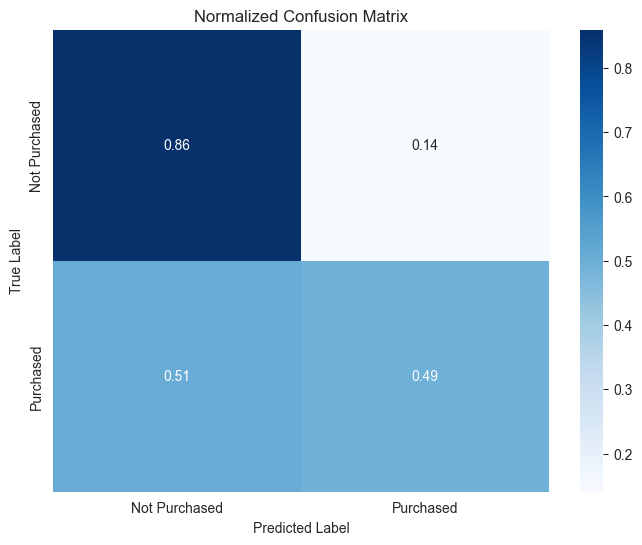

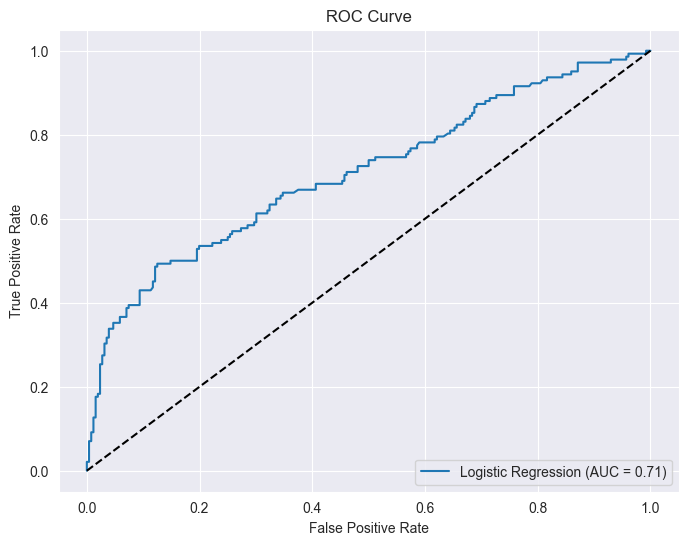

In [31]:
# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_test, y_pred, target_names=['Not Purchased', 'Purchased'])
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Not Purchased', 'Purchased'],
            yticklabels=['Not Purchased', 'Purchased'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Model Evaluation Summary

The logistic regression model's performance has been evaluated using a confusion matrix and ROC curve, yielding the following insights:

### Confusion Matrix
- The normalized confusion matrix provides a visualization of the model's predictions in terms of proportions, which is particularly helpful when dealing with imbalanced datasets.
- The matrix shows the ratio of true positives, false positives, true negatives, and false negatives. High values on the diagonal indicate correct predictions, while off-diagonal values represent errors.
- The model appears to predict 'Not Purchased' more accurately than 'Purchased'. This could suggest a class imbalance or that the model is more biased towards predicting the majority class.

### ROC Curve and AUC
- The ROC curve is a graphical representation of the model's true positive rate against the false positive rate at various threshold settings.
- The AUC score is 0.71, which is a measure of the model's ability to distinguish between the two classes. A score of 1 represents a perfect model, while a score of 0.5 represents a model that does no better than random guessing.
- The closer the ROC curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. The curve of our model suggests moderate predictive power.

These metrics provide a comprehensive view of the model's performance and should be considered when deciding whether the model is suitable for deployment or needs further improvement. Future steps could include investigating model bias, handling class imbalance, or exploring more complex algorithms.

## General Conclusions and Recommendations for Model Improvement

Having evaluated the logistic regression model, we can draw some general conclusions and outline a path for potential improvements:

### Conclusions
- The logistic regression model has provided us with a baseline performance, achieving an accuracy of 76% and an AUC of 0.71.
- The model seems to perform moderately well for a baseline, but there is room for improvement, especially in correctly classifying the positive class (customers who purchased insurance).

### Recommendations for Improvement
1. **Feature Engineering**: Explore creating new features that could better capture the relationships within the data. For instance, interaction terms between features may reveal combined effects on the target variable.

2. **Try More Complex Models**: While logistic regression is interpretable, it may be too simplistic for capturing complex patterns. Consider experimenting with tree-based models like Random Forest or Gradient Boosting, or even ensemble methods for potentially better performance.

3. **Hyperparameter Tuning**: Use grid search or randomized search to fine-tune the hyperparameters of the models you choose to improve their performance.